In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns



array([ 2.26   , 26.877  ,  0.45085])

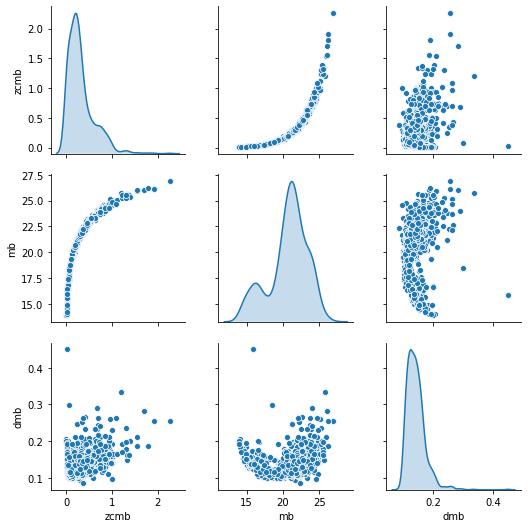

In [3]:
file = 'data/pantheon.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'])
sns.pairplot(data, diag_kind="kde")
plt.savefig("distSNPantheon.png")
data = np.sort(data.values, axis=0)
data[1047, :]

In [4]:
# randomize = np.random.permutation(len(data.values))
# randomize
shuffle = [x for x in range(len(data)) if x%2==1]
even = [x for x in range(len(data)) if x%2==0]
shuffle.extend(even)
np.max(shuffle)

1047

Let's prepare our input data. 

In [5]:
print(data[1047, 0])
data = data[shuffle]

2.26


In [6]:
X = data[:, 0]
y = data[:, 1:]
X.shape, y.shape

((1048,), (1048, 2))

In [7]:
split = 0.8
ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
y_train, y_test = np.split(y, indx)

In [8]:
# scaler = StandardScaler()
# # scaler = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scaler.fit(X.reshape(-1,1))
# # apply transform
# X = scaler.transform(X.reshape(-1,1))
# X

In [9]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden2 = Dense(100, activation='relu')(efirst)
    ehidden3 = Dense(100, activation='relu')(ehidden2)
    elast = Dense(2, activation='linear')(ehidden3)
       
    return elast

In [10]:
batch_size = 64
epochs = 100
input_z = Input(shape = (1,))

In [11]:
snmodel = Model(input_z, model(input_z))
snmodel.compile(loss='mean_squared_error', optimizer = 'adam')

In [12]:
snmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 20,602
Trainable params: 20,602
Non-trainable params: 0
_________________________________________________________________


In [13]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=10,
                                   restore_best_weights=True)]

In [14]:
snmodel_train = snmodel.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1, 
                            validation_data=(X_test, y_test))

Epoch 1/100
27/27 [==============================] - 1s 25ms/step - loss: 198.2846 - val_loss: 226.0952
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 143.6888 - val_loss: 68.9025
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 28.9767 - val_loss: 46.9564
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 9.3987 - val_loss: 14.6571
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 6.1254 - val_loss: 12.3183
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 4.4797 - val_loss: 10.2463
Epoch 7/100
27/27 [==============================] - 0s 5ms/step - loss: 3.3789 - val_loss: 5.4901
Epoch 8/100
27/27 [==============================] - 0s 5ms/step - loss: 2.4733 - val_loss: 5.2548
Epoch 9/100
27/27 [==============================] - 0s 5ms/step - loss: 1.8665 - val_loss: 3.9644
Epoch 10/100
27/27 [==============================] - 0s 5ms/step - loss: 1.4653 - val_loss: 2.5

Epoch 83/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0231 - val_loss: 0.0036
Epoch 84/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0050
Epoch 85/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.0032
Epoch 86/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0045
Epoch 87/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0041
Epoch 88/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0211 - val_loss: 0.0038
Epoch 89/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0208 - val_loss: 0.0257
Epoch 90/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0234 - val_loss: 0.0125
Epoch 91/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0210 - val_loss: 0.0113
Epoch 92/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0031


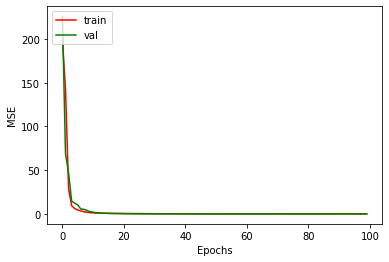

In [15]:
plt.plot(snmodel_train.history['loss'], color='r', )
plt.plot(snmodel_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_sn.png", dpi=200)

In [16]:
pred = snmodel.predict(X_test)
pred.shape

(210, 2)

In [17]:
pred

array([[21.643488  ,  0.14308944],
       [21.651241  ,  0.143184  ],
       [21.654491  ,  0.14322293],
       [21.662767  ,  0.14332402],
       [21.670206  ,  0.14341432],
       [21.683723  ,  0.14357942],
       [21.691479  ,  0.14367375],
       [21.707823  ,  0.14387304],
       [21.709816  ,  0.14389706],
       [21.718304  ,  0.14400062],
       [21.734022  ,  0.14419192],
       [21.746593  ,  0.1443451 ],
       [21.748482  ,  0.14436749],
       [21.76179   ,  0.1445303 ],
       [21.785156  ,  0.1448152 ],
       [21.804018  ,  0.14504406],
       [21.806744  ,  0.14507684],
       [21.815964  ,  0.14519006],
       [21.844048  ,  0.14553109],
       [21.851383  ,  0.14562109],
       [21.86448   ,  0.14578074],
       [21.872337  ,  0.14587617],
       [21.903355  ,  0.14625397],
       [21.916348  ,  0.1464124 ],
       [21.926828  ,  0.14653963],
       [21.946735  ,  0.14678207],
       [21.951975  ,  0.14684585],
       [21.961407  ,  0.14696038],
       [21.966644  ,

In [18]:
r = np.random.uniform(0, 2.3, size=1000)
# r_inv = scaler.inverse_transform(r)
# X = scaler.inverse_transform(X)
# X
print(np.max(X), len(X), X[1047])

2.26 1048 1.9140000000000001


In [19]:
pred_random = snmodel.predict(r)
# pred_random

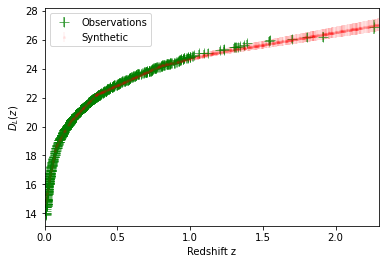

In [39]:
plt.errorbar(X, y[:,0], y[:,1], fmt='g+', markersize=10, label='Observations', alpha=0.6)
plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r*', markersize=3, label='Synthetic', alpha=0.05)
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")

plt.xlim(0,2.3)
plt.legend()
plt.savefig("syntheticSN.png", dpi=300)

In [21]:
# Cosmological constants
Om = 0.27

In [22]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

In [23]:
# z = np.linspace(0, 2.2, 1000)
# # plt.scatter(data[:, 0], data[:, 1], c='g')
# yupp = pred_random[:,0]+pred_random[:,1]
# ylow = pred_random[:,0]-pred_random[:,1]
# plt.errorbar(X, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=1, label='Synthetic data with errors', alpha=0.01, )
# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=64.4), label='$\Lambda CDM$ $H_0 = 64.4$', c='b')
# plt.xlabel("Redshift z")
# plt.ylabel("$H(z)$")
# plt.xlim(0,2.2)
# plt.legend()

# plt.savefig("SyntheticHD.png",dpi=800)

In [24]:
# pred_random.shape, r.shape

In [25]:
# mookHz = np.concatenate((r.reshape(-1,1), pred_random), axis=1)
# np.savetxt("autoEncoderHz.dat",mookHz, delimiter=" ")